In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


In [10]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
imgs = train_images.reshape(-1,28,28,1)
print(imgs.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

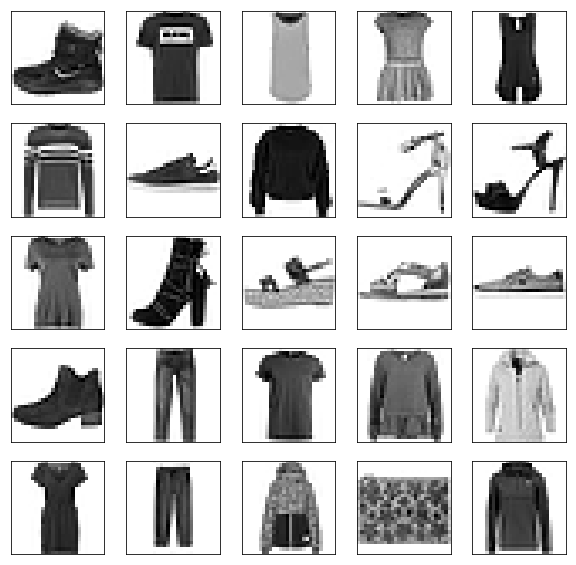

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()


In [4]:
#create batches of training data 
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [5]:
# generator
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh')
])

In [6]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training=False)

In [7]:
#discriminator
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49864364]], shape=(1, 1), dtype=float32)


In [9]:
# Compile the DCGAN
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [10]:
# Define training procedure
seed = tf.random.normal(shape=[batch_size, num_features])

In [11]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print('Epochs {}/{}'.format(epoch+1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [12]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
# train dcgan
x_train_dcgan = x_train.reshape(-1,28,28,1) * 2. -1.



In [17]:
#batch and shuffle data
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)


In [ ]:
train_dcgan(gan, dataset, batch_size, num_features,epochs=10)



  0%|          | 0/10 [00:00<?, ?it/s]

Epochs 1/10
